In [16]:
%matplotlib inline
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization
from keras import backend as K
from keras.datasets import mnist
from keras.layers import add

from keras.models import Model
from keras.utils import plot_model
#from keras.utils.visualize_util import plot

from matplotlib import pyplot as plt

import itertools

from sklearn import svm, metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import numpy as np
# fix random seed for reproducibility
np.random.seed(123)

In [17]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [18]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


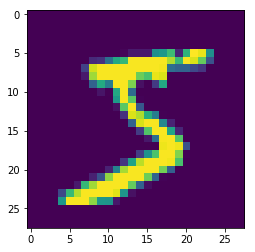

In [19]:
plt.imshow(X_train[0])

In [20]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [21]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [22]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = keras.utils.to_categorical(y_train, num_classes=10)
Y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [108]:
def conv_block(feat_maps_out, prev):
    prev = BatchNormalization(axis=1)(prev) # Specifying the axis and mode allows for later merging
    prev = Activation('relu')(prev)
    prev = Conv2D(feat_maps_out, (3, 3), strides=[1,1], activation='relu', padding='same')(prev) 
    #prev = BatchNormalization(axis=1)(prev) # Specifying the axis and mode allows for later merging
    #prev = Activation('relu')(prev)
    #prev = Conv2D(feat_maps_out, (3, 3), padding='same')(prev) 
    return prev

def skip_block(feat_maps_in, feat_maps_out, prev):
    if feat_maps_in != feat_maps_out:
        # This adds in a 1x1 convolution on shortcuts that map between an uneven amount of channels
        prev = Conv2D(feat_maps_out, (1, 1), activation='relu', padding='same')(prev)
    return prev 

def Residual(feat_maps_in, feat_maps_out, prev_layer):
    '''
    A customizable residual unit with convolutional and shortcut blocks
    Args:
      feat_maps_in: number of channels/filters coming in, from input or previous layer
      feat_maps_out: how many output channels/filters this block will produce
      prev_layer: the previous layer
    '''

    skip = skip_block(feat_maps_in, feat_maps_out, prev_layer)
    conv = conv_block(feat_maps_out, prev_layer)
    
    merged = add([skip,conv])

    print('Residual block mapping '+str(feat_maps_in)+' channels to '+str(feat_maps_out)+' channels built')
    return merged # the residual connection

In [109]:
#Egyszerubb halozat
img_rows = X_train.shape[1]  
img_cols = X_train.shape[2] 

inp = Input((img_rows, img_cols,1))
cnv = Conv2D(32, (3, 3), strides=[1,1], activation='relu', padding='same')(inp)#28*28/4=196 ami = 14*14
r = Residual(32, 32, cnv)
cnv2 = Conv2D(1, (1, 1), padding='same')(r)#ha ide relut tennek???
fl = Flatten()(cnv2)
out = Dense(10, activation='softmax')(fl)

modelr = Model(inputs=inp, outputs=out)

modelr.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy')

Residual block mapping 32 channels to 32 channels built


In [110]:
plot_model(modelr, to_file='model_simple4.png',show_shapes=True)

In [111]:
modelr.fit(
    # Feature matrix
    X_train[:10000], 
    # Target class one-hot-encoded
    Y_train[:10000],
    # Iterations to be run if not stopped by EarlyStopping
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=5),
        ModelCheckpoint(
            'mnist_residualmodel4.hdf5', 
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1,
    validation_split=0.1,
    batch_size=32, 
)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 89s - loss: 0.5391 - val_loss: 0.8258
Epoch 2/100
9000/9000 [==============================] - 85s - loss: 0.2121 - val_loss: 0.2260
Epoch 3/100
9000/9000 [==============================] - 88s - loss: 0.1641 - val_loss: 0.2127
Epoch 4/100
9000/9000 [==============================] - 96s - loss: 0.1352 - val_loss: 0.1861
Epoch 5/100
9000/9000 [==============================] - 102s - loss: 0.1150 - val_loss: 0.1712
Epoch 6/100
9000/9000 [==============================] - 115s - loss: 0.0937 - val_loss: 0.2135
Epoch 7/100
9000/9000 [==============================] - 115s - loss: 0.0861 - val_loss: 0.2005
Epoch 8/100
9000/9000 [==============================] - 113s - loss: 0.0685 - val_loss: 0.2204
Epoch 9/100
9000/9000 [==============================] - 107s - loss: 0.0539 - val_loss: 0.2155
Epoch 10/100
9000/9000 [==============================] - 117s - loss: 0.0466 - val_loss: 0.

In [112]:
model_name =  "mnist_residualmodel4.hdf5"
X = X_test
y = y_test
# Predict classes
modelr.load_weights(model_name)
y_preds = modelr.predict(X) #a sima sklearn_learn nem jo mert mashogy kell predikalni ennel a haloosszeallitasnal
y_preds_max = np.argmax(y_preds,axis=1)

In [113]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Accuracy:0.9530
Precision:
[ 0.95895896  0.97202797  0.92850242  0.95083579  0.95351137  0.97727273
  0.95514781  0.93885602  0.93664203  0.95884774]
Recall:
[ 0.97755102  0.97973568  0.93120155  0.95742574  0.98167006  0.96412556
  0.97807933  0.92607004  0.91067762  0.92368682]
Confusion matrix, without normalization
[[ 958    1    2    0    1    0   10    3    3    2]
 [   0 1112   11    0    0    0    8    0    3    1]
 [  11    4  961   18    1    0    8    7   21    1]
 [   2    0    9  967    2    6    0    9   15    0]
 [   0    2    2    0  964    0    6    2    1    5]
 [   4    0    1    7    2  860    7    2    5    4]
 [   8    3    1    0    3    3  937    0    3    0]
 [   1   12   26    7    3    2    0  952    5   20]
 [   9    4   21   11    8    6    5   16  887    7]
 [   6    6    1    7   27    3    0   23    4  932]]


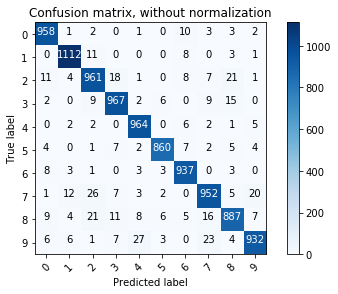

In [114]:
#sklearn accuracy score
print("\nAccuracy:%0.4f"%accuracy_score(y, y_preds_max))
#sklearn precision score
print("Precision:")
print(precision_score(y, y_preds_max,average=None))
#sklearn recall
print("Recall:")
print(recall_score(y, y_preds_max,average=None))
#Confusion matrix
confMatrix = confusion_matrix(y, y_preds_max)
plot_confusion_matrix(confMatrix, classes=[0,1,2,3,4,5,6,7,8,9],
                        title='Confusion matrix, without normalization')